# Train-Holdout Sequential Synthesis Testing

This notebook performs the synthesis using our proposed synthesization approach for the training data only (excludes the holdout data).

In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
from sklearn.mixture import GaussianMixture
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier

import itertools

from bayes_opt import BayesianOptimization

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

from bayesian_bootstrap import bayesian_bootstrap

rng = np.random.RandomState(42)

In [2]:
def cart_pmse_ratio(original_data, synthetic_data_sets):
    
    ### get pmse measures for synthetic data set pairs
    
    null_pmse_list = []
    
    inds = np.arange(len(synthetic_data_sets))
    
    combo_list = list(itertools.combinations(inds, 2))
    
    for combo in combo_list:
    
        s1 = synthetic_data_sets[combo[0]]
        s2 = synthetic_data_sets[combo[1]]
    
        N_orig = s1.shape[0]
        N_synth = s2.shape[0]
    
        c = N_synth/(N_synth+N_orig)
    
        full_X = pd.concat([s1, s2], axis=0).reset_index(drop=True)
    
        full_X = preprocessing.StandardScaler().fit_transform(full_X)

        y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
        cart = DecisionTreeClassifier(min_samples_split=20,
                                      min_samples_leaf=int(np.round(20/3)),
                                      ccp_alpha=0.0001,
                                      max_depth=30)
    
        cart.fit(X=full_X, y=y)
    
        probs = cart.predict_proba(full_X)
    
        pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
        
        null_pmse_list.append(pMSE)
    
    pmse_list = []
    
    for s in synthetic_data_sets:
    
        N_orig = original_data.shape[0]
        N_synth = s.shape[0]
    
        c = N_synth/(N_synth+N_orig)
    
        full_X = pd.concat([original_data, s], axis=0).reset_index(drop=True)
    
        full_X = preprocessing.StandardScaler().fit_transform(full_X)

        y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
        cart = DecisionTreeClassifier(min_samples_split=20,
                                      min_samples_leaf=int(np.round(20/3)),
                                      ccp_alpha=0.0001,
                                      max_depth=30)
    
        cart.fit(X=full_X, y=y)
    
        probs = cart.predict_proba(full_X)
    
        pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
        
        pmse_list.append(pMSE)
    
    return np.array(pmse_list)/(np.mean(null_pmse_list))

In [3]:
def pmse_ratio(original_data, synthetic_data):
    
    N_synth = synthetic_data.shape[0]
    N_orig = original_data.shape[0]
    
    # combine original and synthetic datasets
    full_X = pd.concat([original_data, synthetic_data], axis=0).reset_index(drop=True)
    
    full_X["age"] = full_X["age"].astype('category')
    
    age_dummies = pd.get_dummies(full_X['age'], drop_first=True)
    
    age_dummies.columns = [str(x) for x in age_dummies.columns]
    
    full_X = full_X.drop("age", axis=1)
    
    full_X = pd.concat([full_X, age_dummies], axis=1)
    
    # generate interactions and powers of variables
    poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
    
    full_X = poly.fit_transform(full_X)
    
    full_X = full_X[:,:-36]

    # scale the combined dataset
    full_X = preprocessing.StandardScaler().fit_transform(full_X)
    
    c = N_synth/(N_synth+N_orig)

    y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
    pMSE_model = LogisticRegression(penalty='none', max_iter=1000).fit(full_X, y)
    
    probs = pMSE_model.predict_proba(full_X)
    
    pMSE = 1/(N_synth+N_orig) * np.sum((probs[:,1] - c)**2)
    
    e_pMSE = 2*(full_X.shape[1])*(1-c)**2 * c/(N_synth+N_orig)
        
    return pMSE/e_pMSE

Import the data.

In [4]:
# import standardized lat/long location data
X = pd.read_csv("Data/cleaned_data.csv")

Number of locations from deceased individuals.

In [5]:
np.sum(X.state)

55

Split dataset into continuous and categorical variables.

In [6]:
X

,latitude,longitude,sex,age,state
0,0.944157,-1.010655,male,50s,0
1,0.889746,-0.694899,male,50s,0
2,0.917482,-0.682299,male,30s,0
3,0.916660,-0.682551,male,30s,0
4,0.886074,-0.668883,male,30s,0
...,...,...,...,...,...
6707,0.881500,-0.925307,male,40s,0
6708,-1.728784,1.470871,male,40s,0
6709,-1.548071,1.557316,male,40s,0
6710,-1.549392,1.555785,male,40s,0


In [7]:
cat_columns = X.select_dtypes(['object']).columns

In [8]:
X[cat_columns] = X[cat_columns].apply(lambda x: x.astype('category'))

In [9]:
categories = X[cat_columns].apply(lambda x: x.cat.categories)

In [10]:
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)

In [11]:
categories

sex            Index(['female', 'male'], dtype='object')
age    Index(['0s', '10s', '20s', '30s', '40s', '50s'...
dtype: object

In [12]:
np.mean(X.sex)

0.4620083432657926

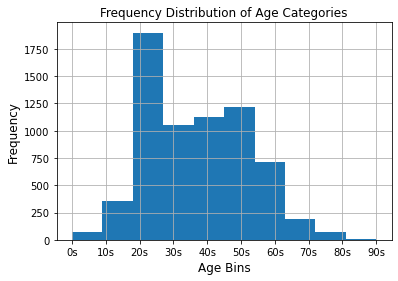

In [13]:
ax = X.age.plot.hist(grid=True, bins=10)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Age Bins', fontsize=12)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(labels=categories['age'])
plt.title("Frequency Distribution of Age Categories")
plt.show()

***

Create and save the training and holdout datasets.

In [14]:
shuffle_X = X.sample(frac=1.0, random_state=42).reset_index(drop=True)

half = int(np.ceil(shuffle_X.shape[0]/2))

train_data = shuffle_X.iloc[:half,:]
val_data = shuffle_X.iloc[half:,:]

In [15]:
train_data.to_csv("Data/synthetic_datasets/synthetic_holdouts/train_dataset.csv", index=False)
val_data.to_csv("Data/synthetic_datasets/synthetic_holdouts/val_dataset.csv", index=False)

***

Testing logistic and multinomial logistic regression synthesizers.

In [16]:
def polynomial_and_standardize(dataset, poly_degree=3, interaction_only=False):
    
    poly = PolynomialFeatures(degree=poly_degree, interaction_only=interaction_only, include_bias=False)
    
    X = poly.fit_transform(dataset)
    
    scaled_X = preprocessing.StandardScaler().fit_transform(X)
    
    return scaled_X

In [17]:
def multinomial_synthesizer(orig_data, synth_data_sets, target, penalty_param, poly_degree=3, interaction_only=False):
    
    mn_model = LogisticRegression(penalty='l1', C=penalty_param, solver='saga', max_iter=1000, multi_class='multinomial', random_state=rng)
    
    X = polynomial_and_standardize(dataset=orig_data, poly_degree=poly_degree, interaction_only=interaction_only)
    
    sXs = [polynomial_and_standardize(dataset=Y, poly_degree=poly_degree, interaction_only=interaction_only) for Y in synth_data_sets]
    
    vals = []
    
    mn_model.fit(X, target)
    
    rng_mn = default_rng()
    
    for Y in sXs:
        
        probs = mn_model.predict_proba(Y)
    
        v = [np.argmax(rng_mn.multinomial(n=1, pvals=p, size=1)==1) for p in probs]
    
        vals.append(pd.Series(v, name=target.name))
    
    return vals

In [18]:
def train_models_mn(#overall parameters
                    train_data,
                    number_synthetic_datasets,
                    # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                    number_gmm_initializations,
                    num_components_,
                    # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                    C_sex_,
                    C_age_,
                    C_state_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, init_params="k-means++", random_state=rng).fit(train_data.loc[:,["latitude", "longitude"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ['latitude', 'longitude']
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for sex MN ##########
    
    synth_sex_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.sex, 
                                             penalty_param=C_sex_)
    
    sXs = [pd.concat([Y, synth_sex_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
        
    ########### Code for age MN ##########
    
    synth_age_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude", "sex"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.age, 
                                             penalty_param=C_age_)
    
    sXs = [pd.concat([Y, synth_age_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
    
    ########### Code for state MN ##########
    
    synth_state_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude", "sex", "age"]], 
                                               synth_data_sets=sXs, 
                                               target=train_data.state, 
                                               penalty_param=C_state_)
    
    sXs = [pd.concat([Y, synth_state_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ###### Calculate pMSE ratios ######
    # pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    pmse_ratios = cart_pmse_ratio(train_data, sXs)
    
    return pmse_ratios, sXs, GMM

In [19]:
def optimize_models_mn(train_data,
                       number_synthetic_datasets,
                       number_gmm_initializations,
                       random_state):

    def evaluate_models(num_components_, C_sex_, C_age_, C_state_):

        pmse_ratios, _, _ = train_models_mn(train_data=train_data,
                                            number_synthetic_datasets=number_synthetic_datasets,
                                            number_gmm_initializations=number_gmm_initializations,
                                            num_components_=int(num_components_),
                                            C_sex_=C_sex_,
                                            C_age_=C_age_,
                                            C_state_=C_state_)
        
        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (200, 800.99),
            "C_sex_": (0.01, 1),
            "C_age_": (0.01, 1),
            "C_state_": (0.01, 1)
        },
        random_state=random_state)

    optimizer.maximize(acq='ei', xi=1e-2)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

In [20]:
nsd = 20
ngi = 5
random_states = [np.random.RandomState(1234), np.random.RandomState(4321), np.random.RandomState(10620), np.random.RandomState(91695), np.random.RandomState(31296)]
# random_states = [np.random.RandomState(1234)]

In [21]:
optimization_results = [optimize_models_mn(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------
|  1        | -0.1274   |  0.1996   |  0.6259   |  0.4434   |  672.0    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  2        | -0.1963   |  0.7822   |  0.2799   |  0.2837   |  681.9    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  3        | -0.08916  |  0.9586   |  0.8772   |  0.3642   |  501.1    |
|  4        | -0.07581  |  0.6866   |  0.7156   |  0.3765   |  537.3    |
|  5        | -0.198    |  0.5081   |  0.02363  |  0.7751   |  730.5    |
|  6        | -0.03696  |  0.123    |  0.694    |  0.2752   |  672.2    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  7        | -0.2534   |  0.9765   |  0.1574   |  0.4669   |  495.7    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  8        | -0.1049   |  0.7789   |  0.8377   |  0.5189   |  537.2    |
|  9        | -0.1287   |  0.1409   |  0.6738   |  0.09963  |  672.5    |
|  10       | -0.1928   |  0.1069   |  0.6086   |  0.3325   |  672.2    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  11       | -0.02852  |  0.9233   |  0.2565   |  0.7494   |  413.3    |
|  12       | -0.07233  |  0.3912   |  0.6115   |  0.6645   |  687.0    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  13       | -0.05232  |  0.8687   |  0.8097   |  0.5983   |  216.3    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  14       | -0.1724   |  0.895    |  0.6688   |  0.4389   |  725.7    |
|  15       | -0.1059   |  0.5034   |  0.453    |  0.1899   |  746.1    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  16       | -0.1034   |  0.9619   |  0.2988   |  0.3296   |  558.0    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  17       | -0.157    |  0.8965   |  0.8994   |  0.993    |  596.1    |
|  18       | -0.1054   |  0.2445   |  0.6663   |  0.01249  |  688.6    |
|  19       | -0.1061   |  0.3194   |  0.9331   |  0.637    |  283.8    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  20       | -0.1751   |  0.9794   |  0.9671   |  0.8913   |  650.3    |
|  21       | -0.1052   |  0.5077   |  0.1225   |  0.8074   |  683.9    |
|  22       | -0.07846  |  0.193    |  0.9023   |  0.9547   |  571.6    |
|  23       | -0.09192  |  0.7563   |  0.4865   |  0.7504   |  623.2    |
|  24       | -0.1165   |  0.1349   |  0.13     |  0.8536   |  456.2    |
|  25       | -0.2615   |  0.01393  |  0.6323   |  0.2302   |  620.8    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  26       | -0.06074  |  0.845    |  0.7577   |  0.2255   |  350.2    |
|  27       | -0.1138   |  0.3884   |  0.9661   |  0.5738   |  600.3    |
|  28       | -0.11     |  0.6671   |  0.2152   |  0.1252   |  239.8    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  29       | -0.1332   |  0.9092   |  0.8591   |  0.4      |  252.6    |
|  30       | -0.05878  |  0.7455   |  0.8918   |  0.2251   |  764.5    |
Final Result:  {'target': -0.028523648406132716, 'params': {'C_age_': 0.9233285616768317, 'C_sex_': 0.2564857918446283, 'C_state_': 0.7493585858232832, 'num_components_': 413.25122682752533}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------
|  1        | -0.04853  |  0.08009  |  0.8169   |  0.7702   |  372.1    |
|  2        | -0.08161  |  0.2012   |  0.9791   |  0.4122   |  655.4    |
|  3        | -0.09768  |  0.09826  |  0.3168   |  0.6227   |  476.4    |
|  4        | -0.1214   |  0.2261   |  0.6669   |  0.6819   |  771.1    |
|  5        | -0.1123   |  0.2884   |  0.6237   |  0.3895   |  440.6    |
|  6        | -0.1158   |  0.4213   |  0.9692   |  0.4845   |  371.6    |
|  7        | -0.142    |  0.5421   |  0.2737   |  0.3963   |  318.3

C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  2        | -0.08922  |  0.9323   |  0.06829  |  0.4413   |  214.9    |
|  3        | -0.08845  |  0.4966   |  0.7043   |  0.7742   |  441.7    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  4        | -0.09549  |  0.9206   |  0.5488   |  0.6903   |  348.1    |
|  5        | -0.05939  |  0.2518   |  0.568    |  0.2733   |  341.4    |
|  6        | -0.02389  |  0.3573   |  0.3924   |  0.3899   |  341.3    |
|  7        | -0.04997  |  0.4602   |  0.7761   |  0.09046  |  274.6    |
|  8        | -0.164    |  0.3758   |  0.6296   |  0.3044   |  542.8    |
|  9        | -0.1758   |  0.253    |  0.3795   |  0.6772   |  341.1    |
|  10       | -0.1623   |  0.2253   |  0.298    |  0.1929   |  341.4    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  11       | -0.06412  |  0.2391   |  0.6035   |  0.9878   |  609.2    |
|  12       | -0.1265   |  0.3845   |  0.6704   |  0.1834   |  274.8    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  13       | -0.1173   |  0.9641   |  0.1305   |  0.968    |  606.3    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  14       | -0.02204  |  0.9637   |  0.7198   |  0.1215   |  455.1    |
|  15       | -0.04598  |  0.07229  |  0.8252   |  0.9058   |  377.1    |
|  16       | -0.1173   |  0.6781   |  0.2469   |  0.1148   |  231.4    |
|  17       | -0.1233   |  0.5355   |  0.06986  |  0.01002  |  452.9    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  18       | -0.1439   |  0.7797   |  0.8438   |  0.6278   |  413.5    |
|  19       | -0.1034   |  0.4671   |  0.6234   |  0.792    |  670.1    |
|  20       | -0.1726   |  0.5506   |  0.2182   |  0.8152   |  791.3    |
|  21       | -0.09558  |  0.1106   |  0.7179   |  0.6304   |  458.7    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  22       | -0.1615   |  0.9628   |  0.1907   |  0.4534   |  774.9    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  23       | -0.04363  |  0.9721   |  0.9901   |  0.3094   |  527.0    |
|  24       | -0.118    |  0.08524  |  0.4429   |  0.798    |  254.5    |
|  25       | -0.1551   |  0.1474   |  0.2185   |  0.1745   |  708.4    |
|  26       | -0.06001  |  0.3839   |  0.272    |  0.5862   |  586.5    |
|  27       | -0.1586   |  0.6941   |  0.8052   |  0.02686  |  566.1    |
|  28       | -0.04556  |  0.7122   |  0.8187   |  0.2889   |  294.0    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  29       | -0.1668   |  0.2335   |  0.3877   |  0.9757   |  786.9    |
|  30       | -0.06694  |  0.1821   |  0.2391   |  0.8223   |  769.2    |
Final Result:  {'target': -0.022041125897779446, 'params': {'C_age_': 0.963687263951218, 'C_sex_': 0.7198438515579624, 'C_state_': 0.1215326596439737, 'num_components_': 455.09402570668027}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  1        | -0.117    |  0.9742   |  0.9885   |  0.4025   |  547.1    |
|  2        | -0.02936  |  0.5623   |  0.3108   |  0.6339   |  280.9    |
|  3        | -0.1885   |  0.5383   |  0.7421   |  0.9112   |  416.8    |
|  4        | -0.1953   |  0.05371  |  0.809    |  0.6584   |  560.9    |
|  5        | -0.08586  |  0.5891   |  0.1727   |  0.8162   |  541.5    |
|  6        | -0.09367  |  0.3959   |  0.1646   |  0.5274   |  268.6    |
|  7        | -0.1682   |  0.1492   |  0.9011   |  0.5255   |  289.9    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  8        | -0.01885  |  0.9643   |  0.182    |  0.2895   |  279.7    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  9        | -0.1901   |  0.01     |  1.0      |  1.0      |  277.1    |
|  10       | -0.1008   |  0.701    |  0.2724   |  0.03199  |  280.3    |
|  11       | -0.05845  |  0.6053   |  0.2258   |  0.6126   |  280.0    |
|  12       | -0.07061  |  0.6461   |  0.2174   |  0.5646   |  281.0    |
|  13       | -0.1084   |  0.4897   |  0.1973   |  0.6193   |  280.6    |
|  14       | -0.2033   |  0.4812   |  0.5109   |  0.4596   |  752.2    |
|  15       | -0.2501   |  0.2659   |  0.1437   |  0.6427   |  281.0    |
|  16       | -0.1065   |  0.4167   |  0.2647   |  0.6141   |  726.3    |
|  17       | -0.02939  |  0.6034   |  0.37     |  0.2261   |  279.2    |
|  18       | -0.06082  |  0.3814   |  0.1149   |  0.7355   |  280.2    |
|  19       | -0.01197  |  0.4521   |  0.3105   |  0.1894   |  245.2    |
|  20       | -0.1398   |  0.1968   |  0.1243   |  0.6434   |  777.7    |
|  21       | -0.01805  |  0.3997   |  0.5296   |  0.1156   |  245.1    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  22       | -0.09738  |  0.8504   |  0.4932   |  0.4348   |  693.0    |
|  23       | -0.1055   |  0.4522   |  0.1953   |  0.232    |  245.3    |
|  24       | -0.146    |  0.3554   |  0.01519  |  0.5443   |  605.6    |
|  25       | -0.06921  |  0.6401   |  0.3281   |  0.4758   |  532.3    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  26       | -0.1159   |  0.8382   |  0.3062   |  0.4535   |  279.9    |
|  27       | -0.05442  |  0.7432   |  0.5775   |  0.3096   |  279.2    |
|  28       | -0.1045   |  0.3869   |  0.2552   |  0.2465   |  279.3    |
|  29       | -0.02903  |  0.6927   |  0.6875   |  0.6902   |  345.0    |
|  30       | -0.1819   |  0.5124   |  0.1563   |  0.3829   |  562.1    |
Final Result:  {'target': -0.011965073517583824, 'params': {'C_age_': 0.4520791165310532, 'C_sex_': 0.3105468203346235, 'C_state_': 0.1894327957851122, 'num_components_': 245.15121582593625}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  1        | -0.2126   |  0.8673   |  0.314    |  0.8171   |  253.5    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  2        | -0.1264   |  0.8085   |  0.7061   |  0.02719  |  341.2    |
|  3        | -0.1797   |  0.2084   |  0.4993   |  0.3039   |  749.8    |
|  4        | -0.0757   |  0.6802   |  0.3533   |  0.118    |  743.9    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  5        | -0.06792  |  0.3767   |  0.2053   |  0.9665   |  360.8    |
|  6        | -0.0623   |  0.5512   |  0.5518   |  0.3116   |  367.6    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  7        | -0.1451   |  0.9913   |  0.1249   |  0.9713   |  446.5    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  8        | -0.02963  |  0.9225   |  0.5351   |  0.5929   |  506.0    |
|  9        | -0.06764  |  0.1598   |  0.9859   |  0.1953   |  728.3    |
|  10       | -0.2198   |  0.2927   |  0.8383   |  0.6348   |  262.5    |
|  11       | -0.02075  |  0.2788   |  0.1343   |  0.1674   |  437.7    |
|  12       | -0.05755  |  0.2      |  0.5688   |  0.146    |  434.0    |
|  13       | -0.1127   |  0.2053   |  0.7583   |  0.7368   |  510.7    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  14       | -0.04788  |  0.9497   |  0.7787   |  0.8589   |  502.5    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  15       | -0.06617  |  0.7818   |  0.6488   |  0.5096   |  736.9    |
|  16       | -0.05152  |  0.09644  |  0.9644   |  0.7739   |  375.6    |
|  17       | -0.1869   |  0.3004   |  0.0786   |  0.4748   |  382.5    |
|  18       | -0.208    |  0.144    |  0.105    |  0.9607   |  372.2    |
|  19       | -0.03776  |  0.06443  |  0.5479   |  0.104    |  436.8    |
|  20       | -0.168    |  0.1861   |  0.8199   |  0.6525   |  504.5    |
|  21       | -0.07921  |  0.132    |  0.3572   |  0.6398   |  437.2    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  22       | -0.123    |  0.9603   |  0.04724  |  0.1338   |  437.5    |
|  23       | -0.1239   |  0.5209   |  0.6244   |  0.2465   |  367.6    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  24       | -0.06227  |  0.8285   |  0.4037   |  0.5599   |  632.9    |
|  25       | -0.03241  |  0.57     |  0.9663   |  0.07523  |  442.9    |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


|  26       | -0.1086   |  0.9559   |  0.1121   |  0.6242   |  592.1    |
|  27       | -0.06209  |  0.1252   |  0.2105   |  0.8851   |  701.6    |
|  28       | -0.05777  |  0.608    |  0.3778   |  0.2502   |  360.9    |
|  29       | -0.08617  |  0.2997   |  0.9456   |  0.9215   |  434.2    |
|  30       | -0.04931  |  0.7266   |  0.2357   |  0.6191   |  277.9    |
Final Result:  {'target': -0.020748125392679038, 'params': {'C_age_': 0.2788291722602872, 'C_sex_': 0.13427626719994148, 'C_state_': 0.1674057743862819, 'num_components_': 437.7048513666689}}


In [22]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

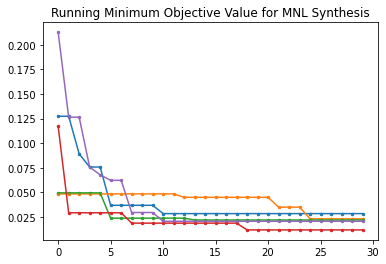

In [23]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.plot(run_targets[2])
plt.scatter(np.arange(len(run_targets[2])), run_targets[2], s=6)
plt.plot(run_targets[3])
plt.scatter(np.arange(len(run_targets[3])), run_targets[3], s=6)
plt.plot(run_targets[4])
plt.scatter(np.arange(len(run_targets[4])), run_targets[4], s=6)
plt.title("Running Minimum Objective Value for MNL Synthesis")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [24]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [25]:
best_params

{'target': -0.011965073517583824,
 'params': {'C_age_': 0.4520791165310532,
  'C_sex_': 0.3105468203346235,
  'C_state_': 0.1894327957851122,
  'num_components_': 245.15121582593625}}

Generate 20 synthetic data sets.

In [26]:
full_ratios, full_sXs, GMM = train_models_mn(train_data=train_data,
                                             number_synthetic_datasets=20,
                                             # hyperparameters for GMM
                                             number_gmm_initializations=ngi,
                                             num_components_=int(best_params['params']['num_components_']),
                                             # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                             C_sex_=best_params['params']['C_sex_'],
                                             C_age_=best_params['params']['C_age_'],
                                             C_state_=best_params['params']['C_state_'])

In [27]:
# num_keep = 20

In [28]:
sXs = full_sXs

In [29]:
# keep = np.array(full_ratios) >= 1.0

In [30]:
# valid_ratios = [full_ratios[i] for i,j in enumerate(keep) if j]

In [31]:
# valid_sXs = [full_sXs[i] for i,j in enumerate(keep) if j]

In [32]:
# indices = np.argsort([np.abs(1-r) for r in full_ratios])[:num_keep]

In [33]:
# sXs = [full_sXs[i] for i in indices]

In [34]:
# ratios = [full_ratios[i] for i in indices]

In [35]:
(1 - np.mean(full_ratios))**2

0.05394282828149445

In [36]:
# (1 - np.mean(ratios))**2

In [37]:
np.mean(full_ratios)

1.2322559542433615

In [38]:
# np.mean(ratios)

In [39]:
# np.mean(valid_ratios)

In [40]:
# np.mean(ratios)

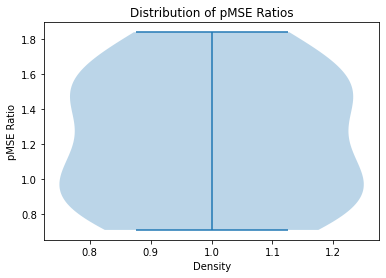

In [41]:
plt.violinplot(full_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

In [42]:
# plt.violinplot(valid_ratios)
# plt.xlabel("Density")
# plt.ylabel("pMSE Ratio")
# plt.title("Distribution of pMSE Ratios")
# plt.show()

In [43]:
# plt.violinplot(ratios)
# plt.xlabel("Density")
# plt.ylabel("pMSE Ratio")
# plt.title("Distribution of pMSE Ratios")
# plt.show()

# Save the synthetic datasets.

In [44]:
for i, sX in enumerate(sXs):
    sX.to_csv("Data/synthetic_datasets/synthetic_holdouts/synthetic_dataset_" + str(i) + ".csv", index=False)

***